In [71]:
!pip install alpha_vantage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
!pip install --upgrade mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import os
import pandas as pd
from decimal import *
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly import subplots
from datetime import datetime
from matplotlib import pyplot  as plt
import mplfinance as mpf



In [74]:
from alpha_vantage.timeseries import TimeSeries

In [75]:
class ScriptData:
    def __init__(self):
        self.api_key = '2W8DDBDNAC2AYLVI'
        self.stored_df = {}

    def __getitem__(self, script):
        return self.stored_df[script]

    def __setitem__(self, script, df):
        self.stored_df[script] = df

    def __contains__(self, script):
        if script in self.stored_df:
            return True

    def fetch_intraday_data(self, script):
        self.ts = TimeSeries(self.api_key, output_format='pandas')

    def convert_intraday_data(self, script):
        df, meta = self.ts.get_intraday(script, interval='60min')
        df.reset_index(level=0, inplace=True)
        df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
        df['volume'] = df['volume'].astype(np.int64)
        df = df[::-1]
        df.reset_index(level=0, inplace=True)
        df = df.drop(['index'], axis=1)
        self.__setitem__(script, df)
        return df

In [76]:
script_data = ScriptData()
script_data.fetch_intraday_data('GOOGL')
script_data.convert_intraday_data('GOOGL')
script_data['GOOGL']

,timestamp,open,high,low,close,volume
0,2023-06-02 16:00:00,124.70,124.8297,124.620,124.73,2444868
1,2023-06-02 17:00:00,124.73,124.7977,124.610,124.67,12763
2,2023-06-02 18:00:00,124.65,124.6500,124.520,124.58,4521
3,2023-06-02 19:00:00,124.57,124.6000,124.490,124.60,8648
4,2023-06-05 04:00:00,124.71,124.7100,124.000,124.00,7915
...,...,...,...,...,...,...
95,2023-06-12 15:00:00,123.70,124.0500,123.360,123.68,5341470
96,2023-06-12 16:00:00,123.64,123.9000,123.530,123.78,1050964
97,2023-06-12 17:00:00,123.76,123.8400,123.600,123.70,691809
98,2023-06-12 18:00:00,123.70,123.9400,123.636,123.94,14926


In [77]:
script_data.fetch_intraday_data('AAPL')
script_data.convert_intraday_data('AAPL')

,timestamp,open,high,low,close,volume
0,2023-06-02 16:00:00,180.95,181.09,180.83,181.0600,4357950
1,2023-06-02 17:00:00,181.06,181.11,180.94,180.9800,52198
2,2023-06-02 18:00:00,180.98,181.06,180.95,181.0600,21791
3,2023-06-02 19:00:00,181.01,181.11,180.96,181.1100,24390
4,2023-06-05 04:00:00,181.22,182.00,181.11,181.6800,96662
...,...,...,...,...,...,...
95,2023-06-12 15:00:00,183.11,183.89,183.01,183.8400,10555651
96,2023-06-12 16:00:00,183.77,183.99,183.74,183.9700,6501900
97,2023-06-12 17:00:00,183.96,184.06,183.79,184.0600,98721
98,2023-06-12 18:00:00,184.01,184.28,183.98,184.2800,42690


In [78]:
'GOOGL' in script_data

True

In [79]:
'AAPL' in script_data

True

In [80]:
'NVDA' in script_data

False

In [81]:
def indicator1(df, timeperiod):
    df['indicator'] = df['close'].rolling(timeperiod).mean()
    df = df[['timestamp', 'indicator']]
    return df

In [82]:
indicator1(script_data['GOOGL'], timeperiod=5)

,timestamp,indicator
0,2023-06-02 16:00:00,NaN
1,2023-06-02 17:00:00,NaN
2,2023-06-02 18:00:00,NaN
3,2023-06-02 19:00:00,NaN
4,2023-06-05 04:00:00,124.516
...,...,...
95,2023-06-12 15:00:00,123.074
96,2023-06-12 16:00:00,123.352
97,2023-06-12 17:00:00,123.594
98,2023-06-12 18:00:00,123.759


In [83]:
indicator1(script_data['AAPL'], timeperiod=5)

,timestamp,indicator
0,2023-06-02 16:00:00,NaN
1,2023-06-02 17:00:00,NaN
2,2023-06-02 18:00:00,NaN
3,2023-06-02 19:00:00,NaN
4,2023-06-05 04:00:00,181.17800
...,...,...
95,2023-06-12 15:00:00,182.88288
96,2023-06-12 16:00:00,183.21156
97,2023-06-12 17:00:00,183.54400
98,2023-06-12 18:00:00,183.85200


In [84]:
class Strategy(ScriptData):
    def __init__(self, script):
        self.script = script
        self.indicator_data = {}
        self.close_data = {}
        ScriptData.__init__(self)

    def get_script_data(self):
        ScriptData.fetch_intraday_data(self, self.script)
        data = ScriptData.convert_intraday_data(self, self.script)
        indicator_data = indicator1(data, timeperiod=5)
        self.indicator_data[self.script] = indicator_data
        data = data[['timestamp', 'close']]
        self.close_data[self.script] = data

    def get_signals(self):

        # 1. BUY (When: If indicator_data cuts close_data upwards)
        # 2. SELL (When: If indicator_data cuts close_data downwards)
        # 3. NO_SIGNAL (When: If indicator_data and close_data don’t cut
        # each other)

        def signal_funct(i):
            if i['indicator'] > i['close']:
                return 'BUY'
            elif i['indicator'] < i['close']:
                return 'SELL'
            else:
                return 'NO_SIGNAL'

        indicator_data = self.indicator_data[self.script]
        df = self.close_data[self.script]
        df = df.merge(indicator_data)
        df['indication_signal'] = df.apply(signal_funct, axis=1)

        ind = df.loc[:, 'indication_signal']
        timestamp = df.loc[:, 'timestamp']

        t = []
        d = []

        for i in range(1, len(df.index)):
            curr, prev = i, i - 1
            if ind[prev] != ind[curr]:
                t.append(timestamp[curr])
                d.append(ind[curr])

        return pd.DataFrame({
            'timestamp': t,
            'signal': d
        })

In [85]:
strategy = Strategy('NVDA')
strategy.get_script_data()
strategy.get_signals()

,timestamp,signal
0,2023-06-05 04:00:00,BUY
1,2023-06-05 07:00:00,SELL
2,2023-06-05 13:00:00,BUY
3,2023-06-05 15:00:00,SELL
4,2023-06-05 16:00:00,BUY
5,2023-06-05 17:00:00,SELL
6,2023-06-05 18:00:00,BUY
7,2023-06-06 06:00:00,SELL
8,2023-06-06 08:00:00,BUY
9,2023-06-06 09:00:00,SELL


In [102]:
# Plotting a candlestick chart
def chart(df2,avg=3):
    df2.timestamp=pd.to_datetime(df2.timestamp) #changing the data type from object to datetime
    df2=df2.set_index("timestamp")
    df2=df2.iloc[::-1]
    mpf.plot(df2['2023-06-05 04:00:00':'2023-06-12  12:00:00'],figratio=(30,10),type='candle',volume=True,style='yahoo')

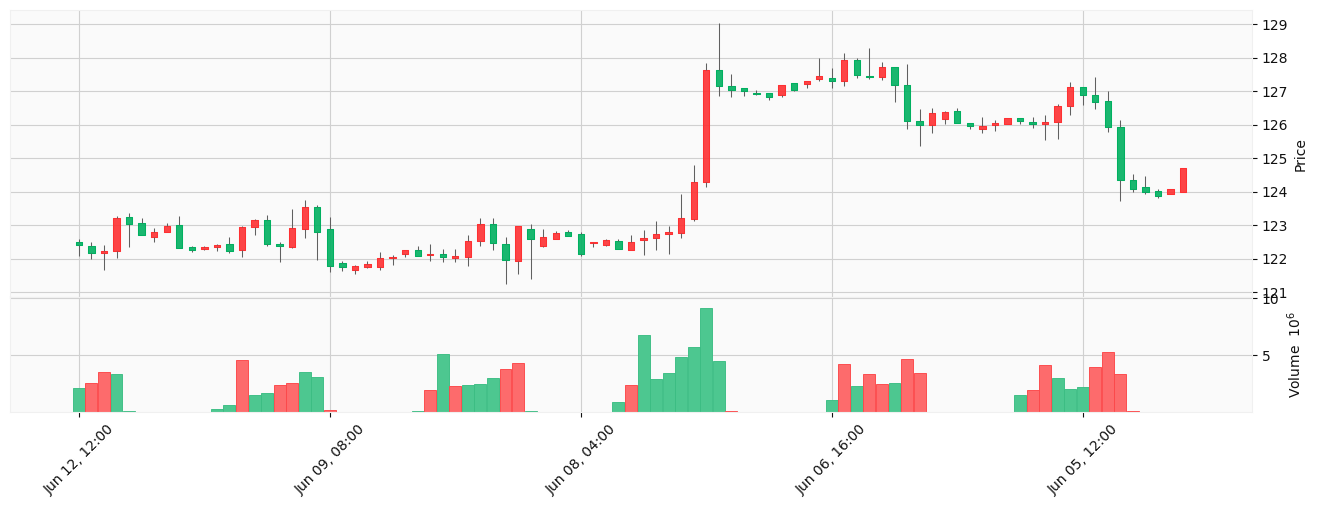

In [103]:
chart(script_data['GOOGL'])

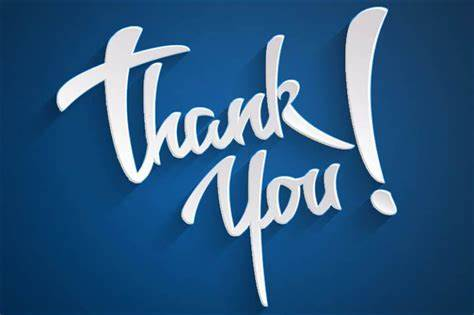